In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_auc_score, precision_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

pd.set_option('display.max_rows', 250)

In [2]:
df_ml_conso_balanced = pd.read_csv('../../datasets/3_ml_patients_consolidation/df_ml_conso_balanced.csv')
df_ml_conso_balanced.head()

,timestamp_start,timestamp_end,qSQI_score,cSQI_score,sSQI_score,kSQI_score,pSQI_score,basSQI_score,classification
0,28971001,28980001,0.57,0.60,-0.35,6.17,0.50,0.83,0
1,28980002,28989002,0.85,0.59,2.97,10.79,0.51,0.94,0
2,29403003,29412003,0.80,0.53,2.50,9.13,0.53,0.91,0
3,29412004,29421004,0.79,0.62,0.93,1.96,0.51,0.79,0
4,57606009,57615009,0.96,0.57,4.13,18.88,0.52,0.98,0


In [3]:
df_ml_conso_balanced = df_ml_conso_balanced.iloc[:,2:]
df_ml_conso_balanced.head()

,qSQI_score,cSQI_score,sSQI_score,kSQI_score,pSQI_score,basSQI_score,classification
0,0.57,0.60,-0.35,6.17,0.50,0.83,0
1,0.85,0.59,2.97,10.79,0.51,0.94,0
2,0.80,0.53,2.50,9.13,0.53,0.91,0
3,0.79,0.62,0.93,1.96,0.51,0.79,0
4,0.96,0.57,4.13,18.88,0.52,0.98,0


In [4]:
def make_performance_report(model, X_train, X_test, y_train, y_test):

    print('\nPerformance report :\n')
    # Feedback of the best model
    print('Best parameters:',model.best_params_)
    print('Score of best estimator on train:',model.best_estimator_.score(X_train, y_train))
    print('Score of best estimator on test:',model.best_estimator_.score(X_test, y_test))

    # Creation of the predictions of y_train & y_test

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Output the accuracy and f1 score for the model
    print()
    print("Accuracy on train set :", accuracy_score(y_train, y_train_pred))
    print("Accuracy on test set :", accuracy_score(y_test, y_test_pred))
    print()

    print()
    print("f1-score on traina set :", f1_score(y_train, y_train_pred))
    print("f1-score on test set :", f1_score(y_test, y_test_pred))
    print()

    print()
    print("Recall on train set :", recall_score(y_train, y_train_pred))
    print("Recall on test set :", recall_score(y_test, y_test_pred))
    print()

    print()
    print("Precision on train set :", precision_score(y_train, y_train_pred))
    print("Precision on test set :", precision_score(y_test, y_test_pred))
    print()

    print()
    print("ROC_AUC_score on train set :", roc_auc_score(y_train, y_train_pred))
    print("ROC_AUC_score on test set :", roc_auc_score(y_test, y_test_pred))
    print()

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                    display_labels=[0,1],
                                    cmap=plt.cm.Blues,
                                    normalize=normalize)
        disp.ax_.set_title(title)

    plt.show()

# I - Preprocessing

In [5]:
df = df_ml_conso_balanced

# Declaration of target and features_list

target_variable = 'classification'
features_list = df.columns.drop(target_variable)

X = df.loc[:, features_list]
y = df.loc[:, target_variable]

# Distinction of categorical features
# (string values, columns index for numpy use)

categorical_features_str = (X.select_dtypes(include=['object']).columns)
categorical_features = [X.columns.get_loc(i) for i in categorical_features_str]

print('categorical columns:',categorical_features)

# Distinction of numeric features 

numeric_features_str = X.columns.drop(categorical_features_str)
numeric_features = [X.columns.get_loc(i) for i in numeric_features_str]

print('numeric columns:',numeric_features)

# Division of dataset Train set & Test set 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convertion of pandas DataFrames to numpy arrays before using scikit-learn

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print('Proportion of class 1 in y_train: ', np.mean(y_train))

print('Proportion of class 1 in y_test: ', np.mean(y_test))

# Declaration of the categorical and numeric transfomers

categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()

# Declaration of the feature encoder

feature_encoder = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
]
)

# Fit of the encoder on X_train and transform of X_train

# Fit on X

feature_encoder.fit(X_train)

print('Shape before feature encoder:', X_train.shape)
X_train = feature_encoder.transform(X_train)
print('Shape after feature encoder:', X_train.shape)

# Transformation of X_test
X_test = feature_encoder.transform(X_test)

categorical columns: []
numeric columns: [0, 1, 2, 3, 4, 5]
Proportion of class 1 in y_train:  0.5000795038956909
Proportion of class 1 in y_test:  0.4996821360457724
Shape before feature encoder: (6289, 6)
Shape after feature encoder: (6289, 6)


# II - Logistic Regression

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.1s finished
GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg']},
             scoring='recall', verbose=5)

Performance report :

Best parameters: {'class_weight': True, 'penalty': 'none', 'solver': 'newton-cg'}
Score of best estimator on train: 0.8142788996660837
Score of best estimator on test: 0.8003814367450731

Accuracy on train set : 0.8142788996660837
Accuracy on 

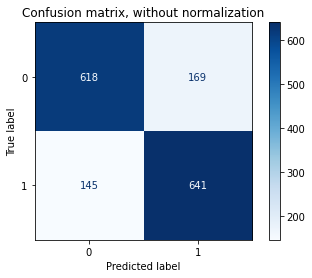

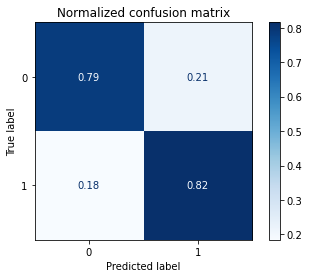

In [6]:
# Declaration of algorithm and parameters for gridsearch

algo = LogisticRegression()
params = {'class_weight' : [True, False],
          'solver' : ['newton-cg',],
          'penalty': ['l1', 'l2', 'elasticnet', 'none']
         }
grid_search_log = GridSearchCV(estimator=algo, param_grid= params, scoring='recall', cv = 5,verbose=5,n_jobs=-1)

# Fitting on train datas

grid_search_log.fit(X_train, y_train)
print(grid_search_log)
make_performance_report(grid_search_log , X_train, X_test, y_train, y_test)

# III - ML - Random Forest Classifier

In [7]:
# Declaration of algorithm and parameters for gridsearch

algo = RandomForestClassifier()
params = {'class_weight' : [None, 'balanced'],
          'min_samples_leaf' : np.arange(6,12,1),
         'max_depth' :  np.arange(6,12,1),
         'max_features' : np.arange(6,12,1),
         'n_estimators' : np.arange(6,12,1),
         'criterion' : ['gini', 'entropy']
         }

RanClassRocAuc =  GridSearchCV(estimator=algo, param_grid= params, scoring='roc_auc', cv = 5,verbose=5,n_jobs=-1)

# grid_search_RFC_list = [RanClassRecall, RanClassAcc, RanClassPrecision, RanClassF1, RanClassRocAuc]

grid_search_RFC_list = [RanClassRocAuc]

# Fitting on train datas

for grid_search in grid_search_RFC_list:
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 3904 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 7936 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 10384 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 13120 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 16144 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 19456 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 23056 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   57.8s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 6,  7,  8,  9, 10, 11]),
                         'min_samples_leaf': array([ 6,  7,  8,  9, 10, 11]),
                         'n_estimators': array([ 6,  7,  8,  9, 10, 11])},
             scoring='roc_auc', verbose=5)

Performance report :

Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'max_features': 6, 'min_samples_leaf': 9, 'n_estimators': 11}
Score of best estimator on train: 0.9080934965813325
Score of best estimator on test: 0.8620470438652257

Accuracy on train set : 0.9080934965813325
Accuracy on test set : 0.8620470438652257


f1-score on traina set : 0.9094611528822055
f1-score on test set : 0.8642901813633521


Recall on train set 

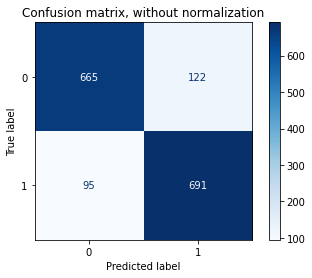

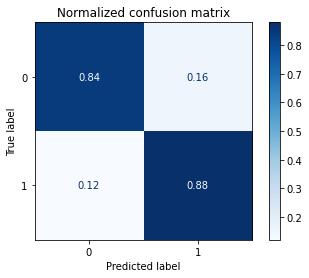

In [8]:
for grid_search in grid_search_RFC_list:
    print(grid_search)
    make_performance_report(grid_search , X_train, X_test, y_train, y_test)

# IV - ML - XGBoost

In [9]:
# Declaration of algorithm and parameters for gridsearch

algo = XGBClassifier()
params = {'min_samples_leaf' : np.arange(6,12,1),
         'max_depth' :  np.arange(6,12,1),
         'max_features' : np.arange(6,12,1),
         'n_estimators' : np.arange(6,12,1),
         'criterion' : ['gini', 'entropy']
         }

params = {'class_weight': [None], 'criterion': ['entropy'], 'max_depth': [11], 'max_features': [6], 'min_samples_leaf': [8], 'n_estimators': [11],
'learning_rate': [0.20, 0.25, 0.30, 0.35, 0.40 ], 'gamma':[ 0.0, 0.1, 0.2]}

XGBClassRocAuc =  GridSearchCV(estimator=algo, param_grid= params, scoring='roc_auc', cv = 5,verbose=5,n_jobs=-1)

# grid_search_list = [RanClassRecall, RanClassAcc, RanClassPrecision, RanClassF1, RanClassRocAuc]

grid_search_XGB_list = [XGBClassRocAuc]

# Fitting on train datas

for grid_search in grid_search_XGB_list:
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  1.1min remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished
[23:30:42] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

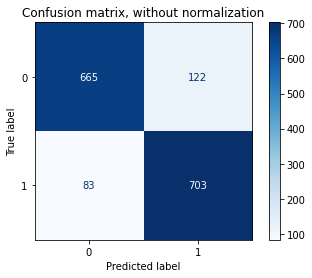

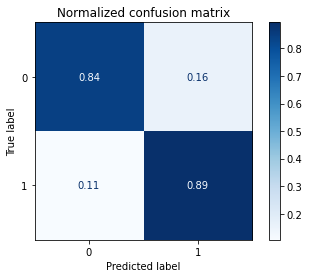

In [10]:
for grid_search in grid_search_XGB_list:
    print(grid_search)
    make_performance_report(grid_search , X_train, X_test, y_train, y_test)

# V - Export of models

In [11]:
# dump feature encoder
dump(feature_encoder, '../../ecg_qc/ml/data_encoder/data_encoder.joblib')

# dump RandomForestClassifier model
dump(grid_search_RFC_list[0].best_estimator_, '../../ecg_qc/ml/models/rfc.joblib')

# dump XGBoostClassifier model
dump(grid_search_XGB_list[0].best_estimator_, '../../ecg_qc/ml/models/xgb.joblib')

['../../ecg_qc/ml/models/xgb.joblib']